# PyTorch Code for Grad-CAM

In [1]:
import torch
import torchvision
import torch.utils.data as Data
import numpy as np
import torchvision.transforms as trans
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg

print('Pytorch Version:' , torch.__version__)

Pytorch Version: 1.5.0


## Dissect & Reconstruct VGG 

We choose `VGG19` to implement `Grad-CAM`. The first thing is to dissect the VGG network, find its last convolutional layer and reconstruct the network. The process is like this:

In [2]:
vgg = torchvision.models.vgg19(pretrained=True)
print('VGG19 Architecture:\n', vgg)

VGG19 Architecture:
 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3)

In [3]:
features_conv = vgg.features[0:36]
max_pool = torch.nn.modules.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
avg_pool = torch.nn.AdaptiveAvgPool2d(output_size=(7, 7))
classifier = vgg.classifier
vgg = torch.nn.Sequential(
    features_conv,
    max_pool,
    avg_pool,
    classifier
)
print('Reconstructed VGG19 Architecture:\n', vgg)

Reconstructed VGG19 Architecture:
 Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kern

## Register a Hook

By reconstructing VGG, we can find a way to register a hook for the last convolutional layer's feature maps:

In [4]:
class VGG(torch.nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = torchvision.models.vgg19(pretrained=True)
        
        # disect the network to access its last convolutional layer(including the ReLU)
        self.features_conv = self.vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the average pool
        self.avg_pool = self.vgg.avgpool
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
         # placeholder for the gradients
        self.gradients = None

    
    # hook for the gradients of the activation(feature maps)
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register a backward hook, the hook will be called every 
        # time a gradient with respect to the Tensor is computed 
        h = x.register_hook(self.activations_hook)
        
        x = self.max_pool(x)
        x = self.avg_pool(x)
        x = x.view((2, -1))
        x = self.classifier(x)
        
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

## Data Preparation

In [5]:
root_dir = 'cam_data'
!tree cam_data 

cam_data
└── dog
    ├── 1.jpg
    └── 2.jpg

1 directory, 2 files


In [6]:
# use the ImageNet transformation
data_transform = trans.Compose([
    trans.Resize((224, 224)), 
    trans.ToTensor(),
    trans.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# define a dataset containing 2 images
dataset = torchvision.datasets.ImageFolder(root=root_dir, transform=data_transform)

dataloader = Data.DataLoader(dataset=dataset, shuffle=False, batch_size=2)

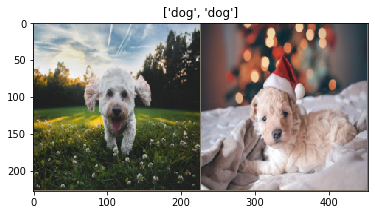

In [7]:
# denormalize and show an image 
def imshow(image, title=None):
    image = image.numpy().transpose((1, 2, 0)) 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image * std + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    if title:
        plt.title(title)

# get a batch of training data
images, labels = next(iter(dataloader))

# make a grid from batch
images = torchvision.utils.make_grid(images)

imshow(images, title=['dog', 'dog'])

## Make Prediction

In [8]:
# generic function to display predictions for a few images
def visualize_model(model, num_images=6):
    was_training = model.training # if true, the model is in training mode otherwise in evaluate mode
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    for step, (images, labels) in enumerate(dataloader):
        
        outputs = model(images)
        preds = torch.max(outputs, 1)[1]
        
        for i in range(images.size(0)):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('Predicted: {}th class'.format(
                preds.data.numpy()[i]))
            imshow(images.data[i])
            
            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    
    model.train(mode=was_training)       

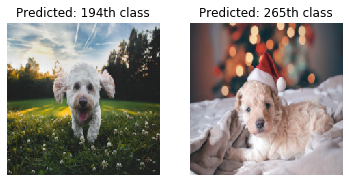

In [9]:
# initialize the VGG model
vgg = VGG()
visualize_model(vgg, 2)

The 194th class of ImageNet is `Dandie Dinmont` while the 265th class is `toy poodle`.

## Draw Class Activation Map

We only deal with one input image and one particular class this time, therefore we need to make minor change to the class `VGG`:

In [10]:
class VGG(torch.nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = torchvision.models.vgg19(pretrained=True)
        
        # disect the network to access its last convolutional layer(including the ReLU)
        self.features_conv = self.vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the average pool
        self.avg_pool = self.vgg.avgpool
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
         # placeholder for the gradients
        self.gradients = None

    
    # hook for the gradients of the activation(feature maps)
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register a backward hook, the hook will be called every 
        # time a gradient with respect to the Tensor is computed 
        h = x.register_hook(self.activations_hook)
        
        x = self.max_pool(x)
        x = self.avg_pool(x)
        x = x.view((1, -1)) # one input image a time
        x = self.classifier(x)
        
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

Then we can make prediction using the changed VGG model:

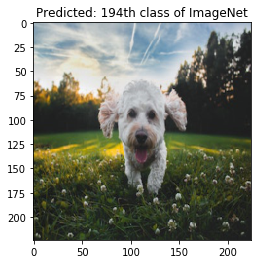

In [11]:
# set bach_size=1
dataloader = Data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

# initialize the VGG model
vgg = VGG()

# set the evaluation mode
vgg.eval()

# get the image from the dataloader
image, _ = next(iter(dataloader))

scores = vgg(image)
pred = 'Predicted: {}th class of ImageNet'.format(torch.max(scores, 1)[1].numpy()[0])
imshow(torchvision.utils.make_grid(image), title=pred)

Now we can draw the class activation map of the input image:

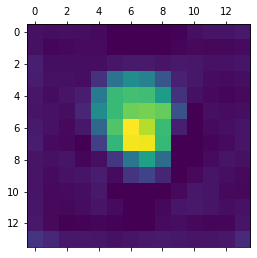

In [12]:
# get the score for class c
# y_c.numpy().detach.shape -> (1,)
y_c = scores[:, 194]
# print('y_c = ', y_c)

# get the gradient of the raw score w.r.t the parameters of the model
y_c.backward()

# pull the gradients out of the model
# gradients.shape -> (1, 512, 14, 14), same as 
# the shape of activations
gradients = vgg.get_activations_gradient()

# pool the gradients across the channels 
# expression (1) in [Paper on Grad-CAM]
# pooled_gradients.shape -> (512, )
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
# activations.shape -> (1, 512, 14, 14), i.e., 512 feature
# maps of spatial size 14x14
activations = vgg.get_activations(image).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
# heatmap.shape -> (14, 14)
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in [Paper on Grad-CAM]
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())
plt.show()

Finally, we can use `OpenCV` to interpolate the heatmap and project it onto the original input image:

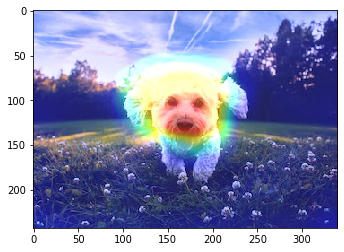

In [13]:
input_img = cv2.imread('./cam_data/dog/1.jpg')
heatmap = cv2.resize(heatmap.numpy(), (input_img.shape[1], input_img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.5 + input_img # 0.5 is a transparency factor
cv2.imwrite('./image/map.jpg', superimposed_img)

cam = mpimg.imread('./image/map.jpg')
plt.imshow(cam)
plt.show()

## Reference 

[Paper on Grad-CAM]`https://arxiv.org/pdf/1610.02391.pdf`

[Implementing Grad-CAM in PyTorch]`https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82`